In [ ]:
# Copyright (c) 2024, NVIDIA CORPORATION.  All rights reserved.
#
# NVIDIA CORPORATION and its licensors retain all intellectual property
# and proprietary rights in and to this software, related documentation
# and any modifications thereto.  Any use, reproduction, disclosure or
# distribution of this software and related documentation without an express
# license agreement from NVIDIA CORPORATION is strictly prohibited.

In [23]:
import os
import cv2
import json
import orjson
import random
import pickle
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from itertools import chain
from collections import Counter, defaultdict

from utils import seg_to_mask, PoissonDiskSampler

In [2]:
DATA_DIR = '/home/ai2lab/work/datasets/'

In [3]:
# load refcoco and refcoco+ and refcocog
with open(f'{DATA_DIR}/RefCOCO/refcoco/instances.json') as f:
    refcoco_instances = json.load(f)
with open(f'{DATA_DIR}/RefCOCO/refcoco/refs(unc).p', 'rb') as f:
    refcoco_refs = pickle.load(f)

with open(f'{DATA_DIR}/RefCOCO/refcoco+/instances.json') as f:
    refcocop_instances = json.load(f)
with open(f'{DATA_DIR}/RefCOCO/refcoco+/refs(unc).p', 'rb') as f:
    refcocop_refs = pickle.load(f)

with open(f'{DATA_DIR}/RefCOCO/refcocog/instances.json') as f:
    refcocog_instances = json.load(f)
with open(f'{DATA_DIR}/RefCOCO/refcocog/refs(umd).p', 'rb') as f:
    refcocog_refs = pickle.load(f)
    
with open(f'{DATA_DIR}/GRES/grefs(unc).json') as f:
    grefs = json.load(f)
with open(f'{DATA_DIR}/GRES/instances.json') as f:
    grefs_instances = json.load(f)

In [4]:
val_test_img_ids = set()
for ref in chain(refcoco_refs, refcocop_refs, refcocog_refs, grefs):
    if not ref['split'] == 'train':
        val_test_img_ids.add(ref['image_id'])
        
with open('refcoco_val_test_img_ids.json', 'w') as f:
    json.dump(list(val_test_img_ids), f)

In [6]:
all_instances = [refcoco_instances, refcocop_instances, refcocog_instances, grefs_instances]
all_refs = [refcoco_refs, refcocop_refs, refcocog_refs, grefs]

[50000, 49856, 49822, 97977]

In [25]:
r_dict = defaultdict(list)

for name, refs, instances in zip(['refcoco', 'refcocop', 'refcocog', 'gres'], all_refs, all_instances):
    for ref in refs:
        if ref['split'] != 'train':
            continue
        
        for sent in ref['sentences']:
            s = sent['sent']
            qid = (ref['image_id'], s)
            
            r_dict[name].append(qid)

In [33]:
for name, qids in r_dict.items():
    print(name, len(qids), len(set(qids)))
    # print(Counter(qids).most_common(5))
    
all_qids = sum(r_dict.values(), [])
print('all', len(all_qids), len(set(all_qids)))
print()

for name1 in r_dict:
    for name2 in r_dict:
        if name1 == name2:
            continue
        print(name1, name2, len(set(r_dict[name1]) & set(r_dict[name2])))

refcoco 120624 113311
refcocop 120191 112441
refcocog 80512 80322
gres 209344 194655
all 530671 379008

refcoco refcocop 7986
refcoco refcocog 294
refcoco gres 113311
refcocop refcoco 7986
refcocop refcocog 237
refcocop gres 7987
refcocog refcoco 294
refcocog refcocop 237
refcocog gres 296
gres refcoco 113311
gres refcocop 7987
gres refcocog 296


In [34]:
refcoco_img_dict, refcoco_ann_dict = {}, {}
for instances in all_instances:
    refcoco_img_dict.update({x['id']: x for x in instances['images']})
    refcoco_ann_dict.update({x['id']: x for x in instances['annotations']})

In [35]:
for refs in all_refs:
    train_phrase_cnt = 0
    val_phrase_cnt = 0
    for ref in refs:
        if ref['split'] == 'train':
            train_phrase_cnt += len(ref['sentences'])
        else:
            val_phrase_cnt += len(ref['sentences'])
    print(f'{len(refs)} refs, train: {train_phrase_cnt}, val: {val_phrase_cnt}')

50000 refs, train: 120624, val: 21586
49856 refs, train: 120191, val: 21373
49822 refs, train: 80512, val: 14498
97977 refs, train: 209344, val: 50515


In [36]:
for refs in all_refs:
    print(Counter([x['split'] for x in refs]))

Counter({'train': 42404, 'val': 3811, 'testA': 1975, 'testB': 1810})
Counter({'train': 42278, 'val': 3805, 'testA': 1975, 'testB': 1798})
Counter({'train': 42226, 'test': 5023, 'val': 2573})
Counter({'train': 78930, 'val': 8163, 'testA': 6266, 'testB': 4618})


In [41]:
all_ref_tuples = []
for refs in all_refs:
    for ref in refs:
        ann_ids = ref['ann_id'] if isinstance(ref['ann_id'], list) else [ref['ann_id']]
        for sent in ref['sentences']:
            all_ref_tuples.append((ref['image_id'], sent['sent'], tuple(ann_ids)))

In [43]:
len(all_ref_tuples), len(set(all_ref_tuples))

(638643, 468350)

In [37]:
poisson_disk_sampler = PoissonDiskSampler(num_samples=100, radius=0.1)

In [10]:
all_ref_data = []

for ref in tqdm(refcoco_refs + refcocop_refs + refcocog_refs + grefs):
    if ref['split'] != 'train':
        continue

    image_id = ref['image_id']
    image_path = f'COCO/train2017/{str(image_id).zfill(12)}.jpg'
    img_w, img_h = refcoco_img_dict[image_id]['width'], refcoco_img_dict[image_id]['height']

    is_gres = isinstance(ref['ann_id'], list)
    no_answer = is_gres and ref['ann_id'][0] == -1

    ann_ids = ref['ann_id'] if is_gres else [ref['ann_id']]

    if no_answer:
        bboxes = []
        points_and_labels = []
    else:
        bboxes = []
        points_and_labels = []
        for ann_id in ann_ids:
            ann = refcoco_ann_dict[ann_id]
            bbox = ann['bbox']
            bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
            scaled_bbox = [bbox[0]/img_w*1000, bbox[1]/img_h*1000, bbox[2]/img_w*1000, bbox[3]/img_h*1000]
            scaled_bbox = [int(round(x)) for x in scaled_bbox]
            scaled_bbox = [
                max(0, scaled_bbox[0]),
                max(0, scaled_bbox[1]),
                min(999, scaled_bbox[2]),
                min(999, scaled_bbox[3]),
            ]
            
            bboxes.append(scaled_bbox)

            gt_mask = seg_to_mask(ann['segmentation'], img_h, img_w)
            
            rand_points = poisson_disk_sampler.sample(bbox)
            rand_points = [(int(x), int(y)) for x, y in rand_points]
            on_masks = gt_mask[np.array(rand_points)[:, 1], np.array(rand_points)[:, 0]]

            scaled_rand_points = [(x/img_w*1000, y/img_h*1000) for x, y in rand_points]
            scaled_rand_points_on_mask = [(int(x), int(y), int(on_mask)) for (x, y), on_mask in zip(scaled_rand_points, on_masks)]
            
            points_and_labels.append(scaled_rand_points_on_mask)
            
    for sent in ref['sentences']:
        phrases = [sent["sent"]]
        answer_counts = '0+' if is_gres else '1'
            
        assert len(bboxes) == len(points_and_labels)

        all_ref_data.append({
            'image_path': image_path,
            'phrases': phrases,
            'answer_counts': answer_counts,
            'bboxes': bboxes,
            'points_and_labels': points_and_labels,
        })

  0%|          | 0/247655 [00:00<?, ?it/s]

In [11]:
with open('processed_data_v2/refcoco_data.json', 'wb') as f:
    f.write(orjson.dumps(all_ref_data))

['girl swinging bat'] 1


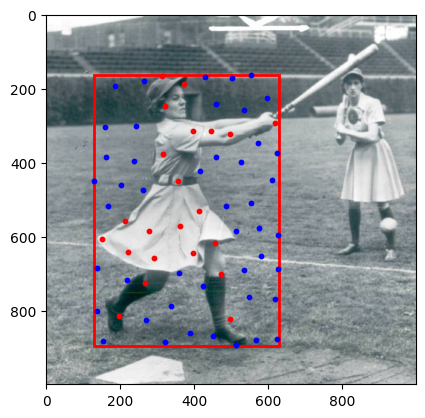

['man in striped shorts'] 1


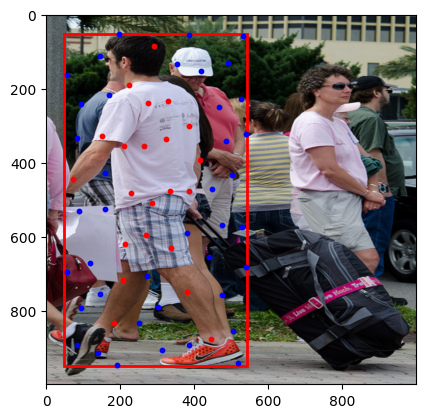

['license plate'] 0+


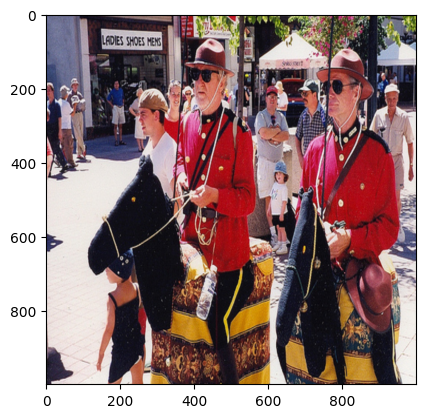

['bowl top right'] 1


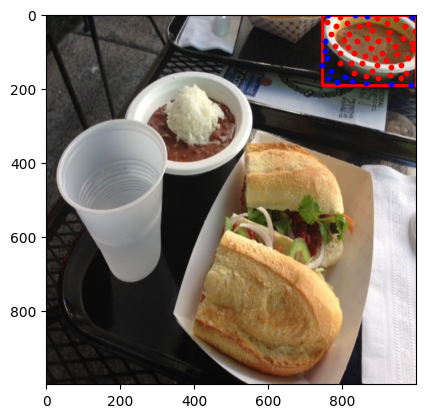

['black dog standing in front of mirror'] 1


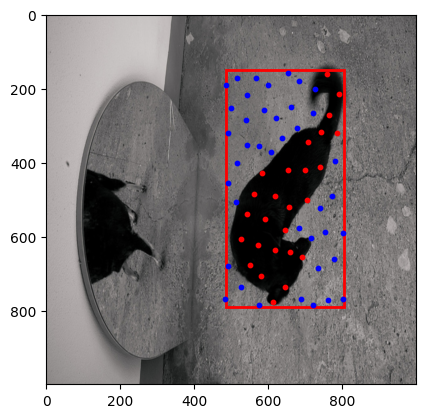

In [12]:
for d in random.sample(all_ref_data, 5):
    
    image_path = os.path.join(DATA_DIR, d['image_path'])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (1000, 1000))
    bboxes = d['bboxes']
    points_and_labels = d['points_and_labels']

    print(d['phrases'], d['answer_counts'])
    plt.imshow(image)
    for bbox in bboxes:
        plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=False, edgecolor='red', linewidth=2))

    for points_and_labels_i in points_and_labels:
        for x, y, on_mask in points_and_labels_i:
            plt.scatter(x, y, c='red' if on_mask else 'blue', s=10)

    plt.show()